In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (get_earth, get_horizons_coord,
                                Helioprojective, propagate_with_solar_surface,
                                HeliocentricEarthEcliptic, get_body_heliographic_stonyhurst)
import sunkit_image
import sunkit_image.coalignment as coalignment
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.time import Time
import eispac
import irispy.io
import pyvista as pv
import h5py
from scipy.interpolate import LinearNDInterpolator
from scipy.io import readsav
import cv2

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize,PowerStretch)
import os
from sun_blinker import SunBlinker
from copy import deepcopy   


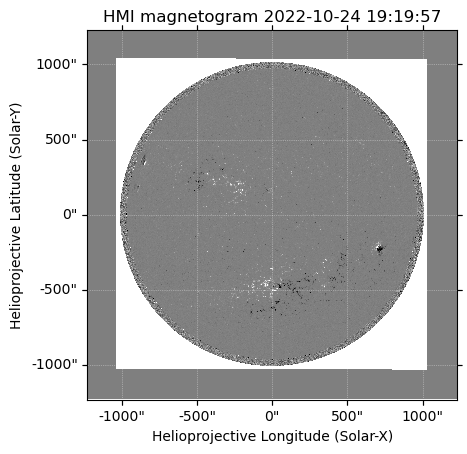

In [2]:
hmi_los_map = sunpy.map.Map("../../src/HMI/20221024/lvl15/hmi.M_45s.20221024_192100_TAI.2.magnetogram.fits")
hmi_los_map.plot_settings['norm'] = plt.Normalize(-500, 500)
hmi_los_map.plot()

In [3]:
hmi_los_map_crop = hmi_los_map.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=hmi_los_map.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=hmi_los_map.coordinate_frame))

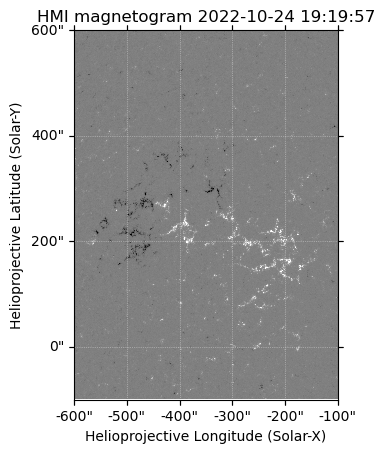

In [4]:
hmi_los_map_crop.plot()

In [90]:
with fits.open("../../src/SOTSP/20221024/lvl2/20221024_184138.fits") as hdul:
    sotsp_header = deepcopy(hdul[0].header)
    # for keys in hdul[1].header.keys():
    #     sotsp_header[keys] = hdul[1].header[keys]
    sotsp_header['CUNIT1'] = 'arcsec'
    sotsp_header['CUNIT2'] = 'arcsec'
    sotsp_header['CTYPE1'] = 'HPLN-TAN'
    sotsp_header['CTYPE2'] = 'HPLT-TAN'
    sotsp_header['CRVAL1'] = sotsp_header['XCEN']
    sotsp_header['CRVAL2'] = sotsp_header['YCEN']
    sotsp_header['CDELT1'] = 0.297 #from Fouhey et al. 2022
    sotsp_header['CDELT2'] = 0.320
    sotsp_header['NAXIS'] = 2
    sotsp_header['RSUN_REF'] = sotsp_header['SOLAR_RA']
    # sotsp_header['DATE-OBS'] = sotsp_header['TSTART']
    # sotsp_header["DATE-END"] = sotsp_header['TEND']
    sotsp_header["DATE-AVG"] = (Time(sotsp_header["TSTART"]) + \
                                (Time(sotsp_header["TEND"]) - Time(sotsp_header["TSTART"]))/2).strftime("%Y-%m-%dT%H:%M:%S")
    
# with fits.open("../../src/SOTSP/20221024/lvl2/sotsp_l2_20221024_190447_3643101203_20221024_184138_magfield_index.fits") as hdul:
#     lsmal_header = deepcopy(hdul[0].header)
#     sotsp_header["PC1_1"] = lsmal_header["PC1_1"]
#     sotsp_header["PC1_2"] = lsmal_header["PC1_2"]
#     sotsp_header["PC2_1"] = lsmal_header["PC2_1"]
#     sotsp_header["PC2_2"] = lsmal_header["PC2_2"]

sotsp_corr_file = readsav("../../src/SOTSP/20221024/lvl2/sotsp_lvl2_missing_col_corrected.sav")
sotsp_btot = deepcopy(sotsp_corr_file['data_new'][0,:,:])
sotsp_btot[~np.isfinite(sotsp_btot)] = 0
sotsp_btot[sotsp_btot<0] = 0
sotsp_btot[sotsp_btot>2000] = 0

sotsp_cont_int = deepcopy(sotsp_corr_file['data_new'][31,:,:])
sotsp_cont_int[~np.isfinite(sotsp_cont_int)] = 0


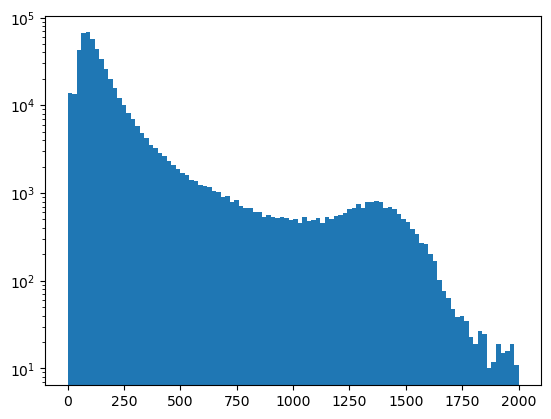

In [91]:
plt.hist(sotsp_btot.flatten(),bins=100,)
plt.yscale("log")

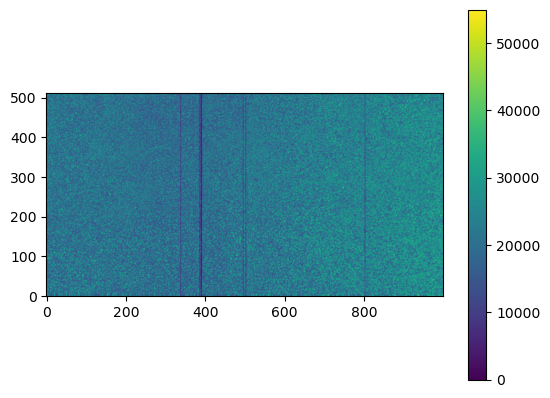

In [64]:
plt.imshow(sotsp_cont_int,origin='lower')
plt.colorbar()

In [37]:
hmi_cont_map = sunpy.map.Map("../../src/HMI/20221024/lvl15/hmi.Ic_45s.20221024_192100_TAI.2.continuum.fits")
hmi_cont_map_crop = hmi_cont_map.submap(SkyCoord(-600*u.arcsec,-100*u.arcsec,frame=hmi_cont_map.coordinate_frame),
                                        top_right=SkyCoord(-100*u.arcsec,600*u.arcsec,frame=hmi_cont_map.coordinate_frame))

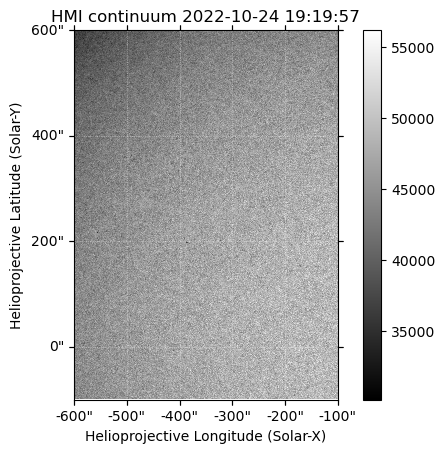

In [32]:
hmi_cont_map_crop.plot()
plt.colorbar()

In [92]:
sotsp_cont_int_blur = cv2.GaussianBlur(sotsp_cont_int[100:-100,100:-100],(1,1),cv2.BORDER_DEFAULT)

/home/yjzhu/anaconda3/envs/sunpy/lib/python3.11/site-packages/matplotlib/image.py:492: RuntimeWarning: invalid value encountered in subtract
  A_scaled -= a_min


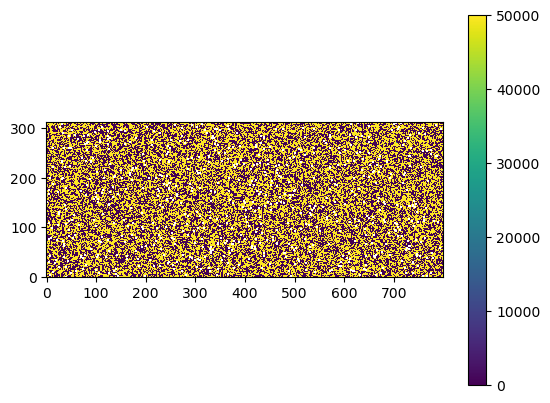

In [93]:
plt.imshow(sotsp_cont_int_blur,origin='lower',vmin=0,vmax=5e4)
plt.colorbar()

In [94]:
sotsp_btot_blur = cv2.GaussianBlur(sotsp_btot,(1,1),cv2.BORDER_DEFAULT)

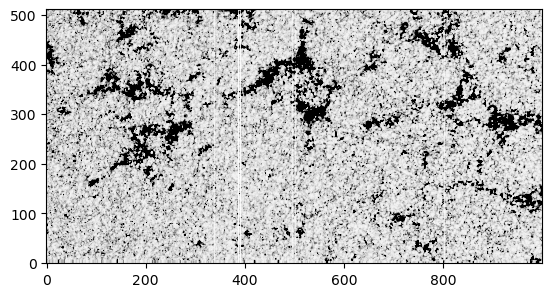

In [95]:
plt.imshow(sotsp_btot,origin='lower',vmin=0,vmax=500,cmap="Greys")

In [49]:
hmi_los_abs_crop = np.abs(hmi_los_map_crop.data)

In [52]:
sift_detector = cv2.SIFT_create(1000)

In [98]:
hmi_los_abs_8bit = cv2.normalize(hmi_los_abs_crop, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
sotsp_btot_8bit = cv2.normalize(sotsp_btot, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

/tmp/ipykernel_566962/1574141542.py:2: RuntimeWarning: invalid value encountered in cast
  sotsp_btot_8bit = cv2.normalize(sotsp_btot, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')


In [110]:
sotsp_btot_8bit = sotsp_btot/2000*255
sotsp_btot_8bit = sotsp_btot_8bit.astype('uint8')

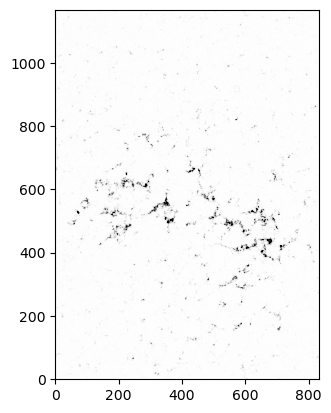

In [81]:
plt.imshow(hmi_los_abs_8bit,origin='lower',vmin=0,vmax=100,cmap="Greys")

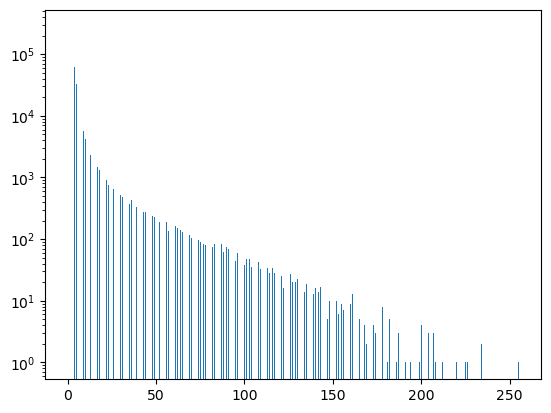

In [106]:
plt.hist(hmi_los_abs_8bit.flatten(),bins=1000)
plt.yscale("log")

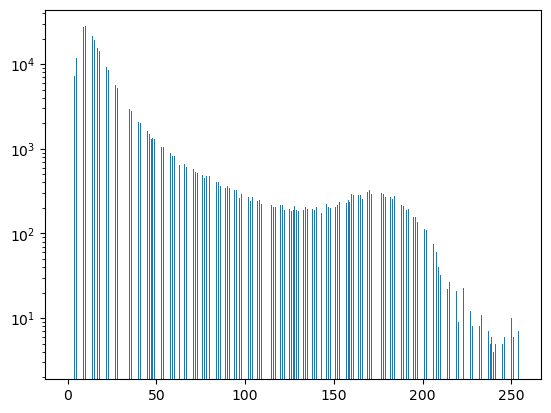

In [111]:
plt.hist(sotsp_btot_8bit.flatten(),bins=1000)
plt.yscale("log")

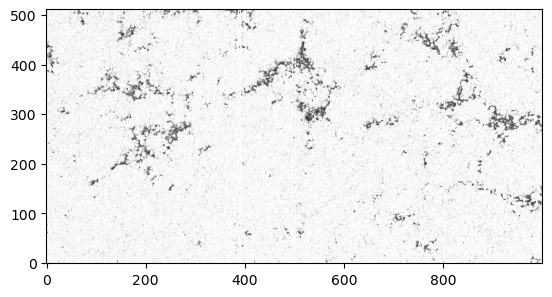

In [112]:
plt.imshow(sotsp_btot_8bit,origin='lower',vmin=0,vmax=255,cmap="Greys")

In [113]:
keyPoint1, des1 = sift_detector.detectAndCompute(hmi_los_abs_8bit, None)
keyPoint2, des2 = sift_detector.detectAndCompute(sotsp_btot_8bit, None)

In [115]:
imgKp_Ref = cv2.drawKeypoints(hmi_los_abs_8bit, keyPoint1, 0, (0,222,0), None)
 
cv2.imshow('Key Points', imgKp_Ref)
cv2.waitKey(0)

QStandardPaths: wrong permissions on runtime directory /run/user/1000/, 0755 instead of 0700
